# Autocorrelation in Climate and Geophysical Data

As we have seen in previous examples, periodic variability and secular trends in time series can lead to autocorrelation at non-zero lags - something that we don't want. There are often ways to remove or adjust time series to handle this type of autocorrelation. However, sometimes, autocorrelation remains and in this section we will explore one technique to adjust statistical tests to account for dependence in time series.

We will explore this technique using an updated example from the climate science literature. [Santer et al. 2000](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/1999JD901105) published a paper on trend analysis of satellite temperature time series using this technique and this paper has now been cited 573 times (at least on of those citations is in one of my papers)!

## Example: Lower Tropospheric Temperature Data

Here, we will revisit the study of Santer et al. (2000) which examines trends in the lower tropospheric temperature (TLT) channel of the Microwave Sounding Unit (MSU) satellite instrument from 1979-1993. Details about the updated TLT data set that we will be working with can be found [here](http://www.remss.com/measurements/upper-air-temperature/).

Since Santer et al. (2000) was published some adjustments have been made to the satellite retrievals for the 1979-1993 time period (you can read a brief discussion about these corrections in this [blog post](http://www.realclimate.org/index.php/archives/2005/08/et-tu-lt/)) and corrections to the more recent part of the TLT record have also been made (you can read a brief discussion of these corrections in this [blog post](https://www.carbonbrief.org/major-correction-to-satellite-data-shows-140-faster-warming-since-1998)).

Let's start by reading in the data.

In [130]:
# Load packages
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',size=14,weight='bold') #set default font size and weight for plots

Read in monthly TLT data starting in Jan. 1979 - Dec. 2019.

In [131]:
filename = 'TLT_19792019.csv'
T = np.squeeze(np.genfromtxt(filename,delimiter=','))

What does the data look like?

In [101]:
# check data shape
T.shape

(492, 3)

There are 492 months (12 months x 41 years) and the three columns correspond to the years, months and temperature data. 

To be consistent with the methods of Santer et al. (2000), we will compute seasonal averages. The typical seasons used in climate data analysis are December-January-February (boreal winter), March-April-May (boreal spring), June-July-August (boreal summer) and September-October-November (boreal fall).

To keep things simple, let's only use years with four complete seasons, so we will extract our data starting in December 1979 and ending in November 2019 and then compute 3-month averages.

In [102]:
# Extract Dec. 1979 - November 2019 and just extract last column (temperature data)
T = T[11:-1,2]

To compute 3-month averages we will do a little loop.

In [103]:
# Calculate seasonal averages (DJF, MAM, JJA, SON)
T_seasons = []
for i in range(0,len(T)-2,3):
    tmp = np.mean(T[i:i+3]) #3-month averages, extract every 3-months and take the mean
    T_seasons.append(tmp)

This loop illustrates what we are trying to accomplish, but there are simpler ways of doing the same thing. If you are not sure what is going on in the line below, print out `T` and print out `T.reshape(-1, 3)` to investigate.

In [104]:
# Alternative way to compute the seasonal averages
T_seasons = np.mean(T.reshape(-1, 3), axis=1)

### Best-Fit Line and the 95\% Confidence Interval

Let's plot the seasonal TLT data and add the best-fit line.

In [105]:
# Create time index for plotting and for regression
time = np.arange(0,len(T_seasons),1)

Text(0.5, 1.0, 'Seasonal TLT Time Series (1980-2019)')

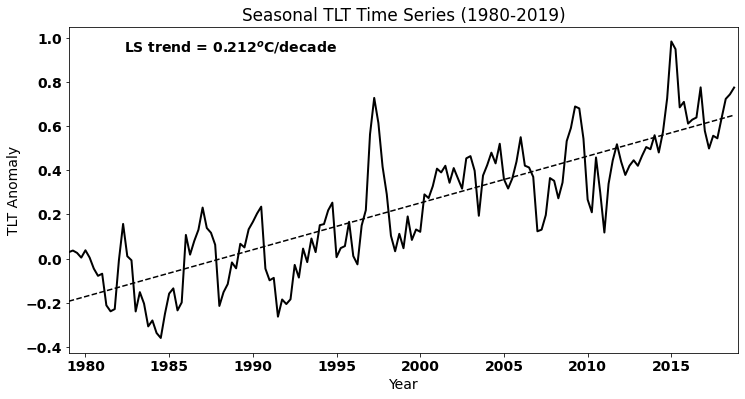

In [106]:
#  Plot the data (update to Fig. 3 of Santer et al. 2000)
plt.figure(figsize=(12,6))

# plot time series
plt.plot(time,T_seasons,'k',linewidth=2)

# calculate best-fit line
a = np.polyfit(time,T_seasons,1)
T_hat = np.polyval(a,time)

# plot best-fit line
plt.plot(time,T_hat,'k',linestyle='--')

# ticks, labels, etc.
plt.xticks(np.arange(4,len(time),20),["1980","1985","1990","1995","2000","2005","2010","2015"])
plt.xlim(0,len(time)) 
plt.text(0.4, 0.925,'LS trend = ' + str(np.round(a[0]*40,3)) + '$^o$C/decade', ha='right', 
         transform=plt.gca().transAxes, color = 'k') #we multiply by 40 because our unit of time is seasons but we
                                                        #want to report the trend in deg C per decade
plt.ylabel("TLT Anomaly")
plt.xlabel("Year")
plt.title("Seasonal TLT Time Series (1980-2019)")

Let's determine if the trend is significantly different from zero, i.e. whether we have a positive trend. Recall that we can use the `st.linregress()` to get the standard error of the slope, which we can use to calculate the 95\% confidence interval on the slope.

In [107]:
#use the alternate way to calculate the best fit parameters
slope, intercept, r_value, p_value, std_err = stats.linregress(time,T_seasons)

#find t_crit for our 95% confidence intervals on our slope
t_crit = stats.t.ppf(0.975,len(time)-2)
confidence_interval = t_crit*std_err
print("The true value of the slope is then", np.round(slope*40,3), "+/-", np.round(confidence_interval*40,3), "degC/decade")

The true value of the slope is then 0.212 +/- 0.021 degC/decade


Thus, we have a positive trend that is statistically significant. 

### Autocorrelation

We're done, right? Not yet. From the plot, it looks like our data set has substantial autocorrelation (a secular trend, but also other non-random variability). Let's check:

In [108]:
#np.correlate actually gives the covariance. We need to find the covariance of the deviations from the mean and then
#divide the the tau=0 covariance, i.e., the variance to get the correlation

Tcorr = np.correlate((T_seasons-np.mean(T_seasons)),(T_seasons-np.mean(T_seasons))/(len(T_seasons)*np.var(T_seasons)),'same')

We can plot the autocorrelation function for seasonal TLT to see whether we have substantial autocorrelation.

Text(0.5, 0, 'Lag')

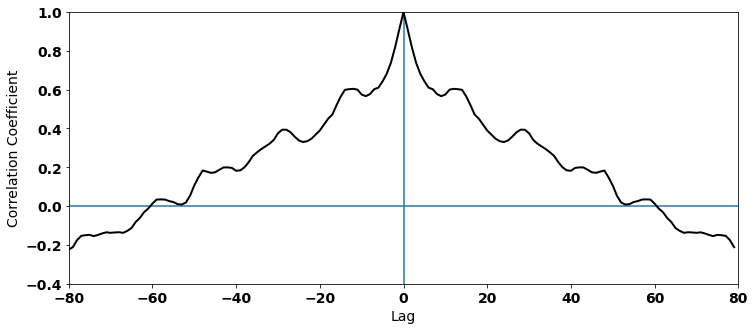

In [109]:
#plot the autocorrelation function
fig = plt.figure(figsize=(12,5))

# x-value for plotting
x = np.arange(0,len(T_seasons),1)
series = [i-len(T_seasons)/2.0 for i in x]

#plot series
plt.axhline(0)
plt.axvline(0)
plt.plot(series,Tcorr,'k',linewidth=2)
plt.xlim(-80,80)
plt.ylim(-0.4,1)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag')

What do you see? We clearly have high autocorrelation at non-zero lags. This autocorrelation in the temperatures ends up in our residuals:

In [112]:
# calculate residuals
resids = T_seasons - T_hat

3.712308238590367e-17


In [113]:
# calculate autocorrelation of residuals
rcorr = np.correlate(resids/(np.std(resids)),resids/(np.std(resids)*len(resids)),'same')

Let's add the autocorrelation of our residuals to the above plot. For simplicity and so we can zoom in on the non-zero lags, let's just plot the positive lags.

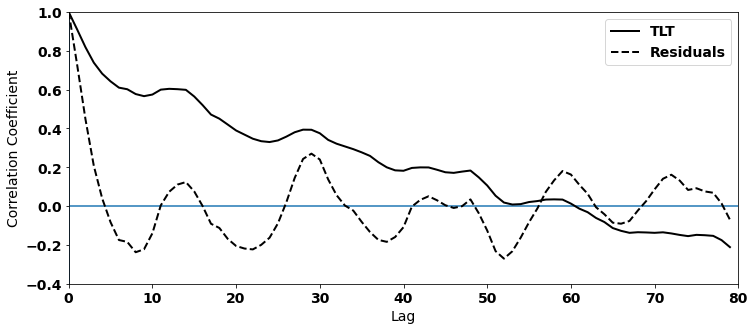

In [122]:
#plot the autocorrelation function
fig = plt.figure(figsize=(12,5))

# x-value for plotting
x = np.arange(0,len(T_seasons),1)
series = [i-len(T_seasons)/2.0 for i in x]

#plot series
plt.axhline(0)
plt.axvline(0)
plt.plot(series[int(len(T_seasons)/2):],Tcorr[int(len(T_seasons)/2):],'k',linewidth=2,label="TLT")
plt.plot(series[int(len(T_seasons)/2):],rcorr[int(len(T_seasons)/2):],'k--',linewidth=2,label="Residuals")
plt.xlim(0,80)
plt.ylim(-0.4,1)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag')
plt.legend(loc='upper right')

We can definitely see that removing the trend in the data (`T_seasons - T_hat`) has weakened the autocorrelation at non-zero lags. However, the autocorrelation function is clearly not zero - some autocorrelation remains. 

Let's perform a Durbin-Watson test to see whether are residuals violate the independence assumption. Recall that a value of close to 2 indicates no autcorrelation, a value between 0 and 2 indicates positive autocorrelation and a value between 2 and 4 indicates negative autocorrelation.

In [129]:
#  test for autocorrelation of residuals
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(resids)
print(dw)

0.522534424626424


We get a value that is definitely closer to zero than it is to 2. The residuals are positively autocorrelated.

### Why does this matter?

So, why does this matter? If the residuals are autocorrelated, then we have violated an assumption of linear regression. Thus, the question becomes: how much can we trust the result of our significance test that we performed on the slope above? 

Many, *many* climate and geophysical time series contain autocorrelation - we often can't avoid it - and, thus techniques have been developed to account for this autocorrelation. The technique that we will discuss involves accounting for the persistence (another word for positive autocorrelation) in our time series by decreasing our sample size, $N$. Persistence/autocorrelation in a data set means that our sample size is actually an overestimate, because each data point is not independent of those around it. So, we can decrease $N$ in order to reflect the degree of autocorrelation in our data.

This technique seems relatively logical and straight-forward, but in order to establish by **how much** we need to decrease $N$, we need to introduce the concept of **red-noise**.